## Training

In [2]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import os
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [4]:
# Load the data
h5f = h5py.File('data/data_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3012, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [5]:
from models import Squeeze_model

In [6]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [7]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*16
nb_epochs = 200
l_rate = 1e-4
decay_rate = l_rate / nb_epochs

In [8]:
data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [9]:
# Build the model and train
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)
decay_rate = l_rate / nb_epochs
model.compile(optimizer=optimizers.adam(lr=l_rate),# decay=decay_rate, beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')
              #target_tensors=[staging_area_callback.target_tensor],
              #fetches=staging_area_callback.extra_ops)

In [10]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-original.h5"

#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [11]:
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, 
                              callbacks=callbacks_list)

Epoch 1/200
47/47 [==============================] - 13s 266ms/step - loss: 3.3215 - val_loss: 1.6663

Epoch 00001: val_loss improved from inf to 1.66626, saving model to ./weights/weights-original.h5
Epoch 2/200
47/47 [==============================] - 5s 115ms/step - loss: 1.5006 - val_loss: 1.4340

Epoch 00002: val_loss improved from 1.66626 to 1.43399, saving model to ./weights/weights-original.h5
Epoch 3/200
47/47 [==============================] - 5s 115ms/step - loss: 1.4783 - val_loss: 1.4548

Epoch 00003: val_loss did not improve from 1.43399
Epoch 4/200
47/47 [==============================] - 6s 118ms/step - loss: 1.4167 - val_loss: 1.4091

Epoch 00004: val_loss improved from 1.43399 to 1.40914, saving model to ./weights/weights-original.h5
Epoch 5/200
47/47 [==============================] - 6s 120ms/step - loss: 1.4203 - val_loss: 1.2696

Epoch 00005: val_loss improved from 1.40914 to 1.26957, saving model to ./weights/weights-original.h5
Epoch 6/200
47/47 [===============


Epoch 00052: val_loss did not improve from 1.20350
Epoch 53/200
47/47 [==============================] - 5s 116ms/step - loss: 0.4399 - val_loss: 1.3711

Epoch 00053: val_loss did not improve from 1.20350
Epoch 54/200
47/47 [==============================] - 5s 114ms/step - loss: 0.3341 - val_loss: 1.4706

Epoch 00054: val_loss did not improve from 1.20350
Epoch 55/200
47/47 [==============================] - 5s 114ms/step - loss: 0.3454 - val_loss: 1.4174

Epoch 00055: val_loss did not improve from 1.20350
Epoch 56/200
47/47 [==============================] - 6s 119ms/step - loss: 0.3187 - val_loss: 1.3544

Epoch 00056: val_loss did not improve from 1.20350
Epoch 57/200
47/47 [==============================] - 6s 118ms/step - loss: 0.2690 - val_loss: 1.4133

Epoch 00057: val_loss did not improve from 1.20350
Epoch 58/200
47/47 [==============================] - 6s 118ms/step - loss: 0.2608 - val_loss: 1.3654

Epoch 00058: val_loss did not improve from 1.20350
Epoch 59/200
47/47 [====

47/47 [==============================] - 5s 117ms/step - loss: 0.1862 - val_loss: 1.2305

Epoch 00106: val_loss did not improve from 1.20350
Epoch 107/200
47/47 [==============================] - 6s 118ms/step - loss: 0.1731 - val_loss: 1.2568

Epoch 00107: val_loss did not improve from 1.20350
Epoch 108/200
47/47 [==============================] - 6s 118ms/step - loss: 0.1632 - val_loss: 1.3275

Epoch 00108: val_loss did not improve from 1.20350
Epoch 109/200
47/47 [==============================] - 5s 117ms/step - loss: 0.2150 - val_loss: 1.5295

Epoch 00109: val_loss did not improve from 1.20350
Epoch 110/200
47/47 [==============================] - 6s 120ms/step - loss: 0.1673 - val_loss: 1.2711

Epoch 00110: val_loss did not improve from 1.20350
Epoch 111/200
47/47 [==============================] - 6s 118ms/step - loss: 0.2003 - val_loss: 1.3605

Epoch 00111: val_loss did not improve from 1.20350
Epoch 112/200
47/47 [==============================] - 6s 120ms/step - loss: 0.1878 

47/47 [==============================] - 6s 119ms/step - loss: 0.1866 - val_loss: 1.2942

Epoch 00159: val_loss did not improve from 1.20350
Epoch 160/200
47/47 [==============================] - 5s 116ms/step - loss: 0.1637 - val_loss: 1.2419

Epoch 00160: val_loss did not improve from 1.20350
Epoch 161/200
47/47 [==============================] - 6s 119ms/step - loss: 0.1565 - val_loss: 1.3911

Epoch 00161: val_loss did not improve from 1.20350
Epoch 162/200
47/47 [==============================] - 5s 116ms/step - loss: 0.1470 - val_loss: 1.2787

Epoch 00162: val_loss did not improve from 1.20350
Epoch 163/200
47/47 [==============================] - 6s 118ms/step - loss: 0.1864 - val_loss: 1.3110

Epoch 00163: val_loss did not improve from 1.20350
Epoch 164/200
47/47 [==============================] - 5s 116ms/step - loss: 0.1686 - val_loss: 1.2802

Epoch 00164: val_loss did not improve from 1.20350
Epoch 165/200
47/47 [==============================] - 5s 115ms/step - loss: 0.1655 

In [12]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_original.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

In [13]:
# Save the weights
# model.save_weights('weights/weights_original.h5')

In [14]:
model.load_weights(filepath)

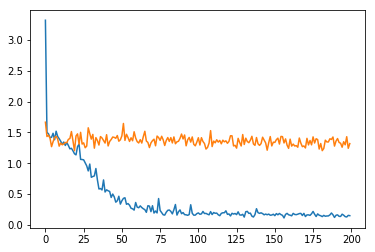

In [15]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

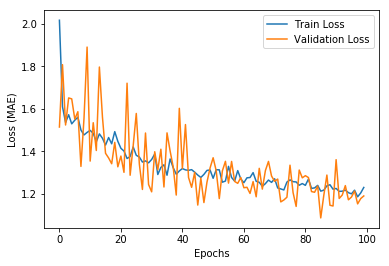

In [41]:
import pickle
with open("weights/history_cano_rotated_random.pickle", 'rb') as f:
    history = pickle.load(f)
    
plt.figure()
plt.plot(history['loss'])#[:100])
plt.plot(history['val_loss'])#[:100])
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.legend(['Train Loss', 'Validation Loss'])
plt.savefig('nn-cano-rotated-random.png', format='png', dpi=1000)
plt.show()

In [16]:
from sklearn.metrics import r2_score

In [17]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=train_y[:2000], y_pred=model.predict(train_x[:2000]))
print("Train r2: ", train_r2)

Train r2:  0.48583047746


In [18]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
test_r2 = r2_score(y_true=test_y, y_pred=model.predict(test_x))
print("Test r2: ", test_r2)

Test r2:  0.314956687271
